In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import gym
%matplotlib inline
import torch 
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import os 
import collections
import torch.nn.functional as F
import copy 

import sys
# Import python files 
# !wget https://github.com/clementbernardd/Count-Based-Exploration/raw/main/zip/python.zip
# !unzip python.zip
# !rm python.zip

# !wget https://github.com/clementbernardd/Count-Based-Exploration/raw/main/zip/models.zip
# !unzip models.zip
# !rm models.zip

# !wget https://github.com/clementbernardd/Count-Based-Exploration/raw/main/zip/results.zip
# !unzip results.zip
# !rm results.zip

sys.path.append('../python')

from RL_algorithm import *
from utils import * 
from buffer import * 
from ddqn_agent import *
from qnetwork import *
from simhash import * 
from train import * 
from dqn_agent import *
from q_learning import * 
from sarsa import * 
from discretize import * 
from dueling_qnetwork import * 
from dueling_dqn_agent import * 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
%cd ..

/Users/clementbernard/Documents/Cours/Canada/Cours/Hiver2021/INF8225/Projet/Count-Based-Exploration


# Environment

In [3]:
ENVS = {'acrobot' : gym.make('Acrobot-v1') ,\
        'cartpole' : gym.make('CartPole-v0'),
        'mountain' : gym.make('MountainCar-v0')}
DISCRETIZE_ENVS = {'taxi' : gym.make("Taxi-v3").env, \
        'acrobot' :  Discretize(gym.make('Acrobot-v1'), N = 1000000000)}

## Name of the models 

In [4]:
NAME_MODELS = {'q_learning' : Q_learning, 'sarsa' : SARSA, 'dqn' : DQNAgent, 'ddqn' : DDQNAgent,'dueling_dqn' : DuelingDDQNAgent}

In [5]:
class Models(object) : 
  ''' Model for a given environment '''
  def __init__(self, name_env, hp_params, NAME_MODELS = NAME_MODELS, ENVS = ENVS,DISCRETIZE_ENVS = DISCRETIZE_ENVS) : 

    self.name_env = name_env
    self.hp_params = hp_params
    self.models = {model : [None, None] for model in list(hp_params.keys())}
    self.NAME_MODELS = NAME_MODELS
    self.ENVS = ENVS
    self.DISCRETIZE_ENVS = DISCRETIZE_ENVS
    # self.conversion_models = {'Q_learning' : Q_learning, 'Sarsa' : SARSA, 'DQN' : DQNAgent, 'DDQN' : DDQNAgent, 'Dueling_dqn' : DuelingDQNAgent}
    self.results = {model : [None, None] for model in list(hp_params.keys())}
    self.hashs = {model : None for model in list(hp_params.keys())}
    

  def initialise(self, hp_params = None ) : 
    ''' Initialise all the models with the given hyperparameters '''
    if hp_params is None : 
      hp_params = self.hp_params
    for model in hp_params : 
      if (model == 'q_learning' or model == 'sarsa') and (self.name_env == 'acrobot' or self.name_env == 'taxi') :
        hp_params[model]['env'] = self.DISCRETIZE_ENVS[self.name_env] 
      else : 
        # hp_params[model]['env'] = self.ENVS[self.name_env]
        hp_params[model]['state_size'] = len(self.ENVS[self.name_env].observation_space.sample())
        hp_params[model]['action_size'] = self.ENVS[self.name_env].action_space.n

      # Get the baseline models 
      hp_params[model]['name'] = os.path.join(self.name_env, model, model+'77')
      self.models[model][0] = self.NAME_MODELS[model](**hp_params[model])
      self.models[model][0].load(hash = False)
      # Get the count-based models 
      new_params = copy.deepcopy(hp_params)
      new_params[model]['name']+='_cb'
      self.models[model][1] = self.NAME_MODELS[model](**new_params[model])
      self.models[model][1].load(hash = False)
      # Get the plotting curves 

      name = os.path.join('results', self.name_env,  model, model)
      self.results[model][0] = load_obj(name)

      name_cb = name+'_cb'
      self.results[model][1] = load_obj(name_cb)
  
      name_hash = os.path.join('results', self.name_env, model, 'hash')
      try : 
        self.hashs[model] = load_obj(name_hash)
      except FileNotFoundError : 
        pass

  def plot_results(self, figsize = (18,8),  nrows = 2, ncols = 2) : 
    ''' Plot the rewards for the different models '''
    fig, ax = plt.subplots(figsize = figsize, nrows = nrows, ncols = ncols)
    ax = np.array(ax)
    colors = ['b','orange']
    labels = ['Epsilon-greedy', 'Count-based']
    name_models = list(self.hp_params.keys())
    
    for i,model in enumerate(name_models) :

      baseline = self.results[model][0]
      count_based = self.results[model][1]

      models = [baseline, count_based]

      for j in range(2) : 
        means, upper_b, upper_h = get_upper_bounds(models[j])
        X = np.arange(len(means))
        ax.flatten()[i].plot(X, means, alpha = 0.8, color = colors[j])
        ax.flatten()[i].fill_between(X , upper_b, upper_h, color = colors[j], alpha = 0.3, label = labels[j])
        ax.flatten()[i].set_xlabel('Episode')
        ax.flatten()[i].set_ylabel('Rewards')
        ax.flatten()[i].grid(True)
        ax.flatten()[i].set_title(model)
        ax.flatten()[i].legend()

    fig.suptitle('Results with environment : {}'.format(self.name_env), fontsize=15)


  def plot_histogram(self,figsize = (18,8), nrows = 2, ncols = 2) : 
    ''' Plot the histograms of the stats '''
    fig, ax = plt.subplots(figsize = figsize, nrows = nrows, ncols = ncols)
    ax = np.array(ax)
    
    name_models = list(self.hashs.keys())
    
    for i,model in enumerate(name_models) :
      try : 
        hash = self.hashs[model]
        if model == 'q_learning' or model == 'sarsa': 
          hash = np.array(list((hash.values()))).mean(axis = 0 ).squeeze()
        else : 
          hash = get_hashes_mean(hash)

        ax.flatten()[i].bar(np.arange(len(hash)), hash, 1.5, align = 'center',log=True)
        ax.flatten()[i].set_xlabel('States')
        ax.flatten()[i].set_ylabel('Count')
        ax.flatten()[i].set_title(model)
        ax.flatten()[i].grid(True)

      except : 
        pass

    fig.suptitle('States count with environment : {}'.format(self.name_env), fontsize=15)


# Hyperparameters

In [6]:
all_params = {}
all_params_discrete = {} 

In [7]:
models = {}
models_discrete = {}

## Taxi

### Hyperparameters 

In [8]:
all_params_discrete['taxi'] = {
    'q_learning': {
          'alpha' : 0.01,
          'gamma' : 0.99,
          'epsilon' : 0.1,
          'beta' : 0.1,
    },
    'sarsa' : {
          'alpha' : 0.01,
          'gamma' : 0.99,
          'epsilon' : 0.1,
          'beta' : 0.1,
    }
}

In [9]:
CURRENT_ENV = DISCRETIZE_ENVS['taxi']
NAME_ENV = 'taxi'

In [10]:
models_discrete[NAME_ENV] = Models(name_env = NAME_ENV, hp_params = all_params_discrete[NAME_ENV])

In [11]:
models_discrete[NAME_ENV].initialise()

### Rewards

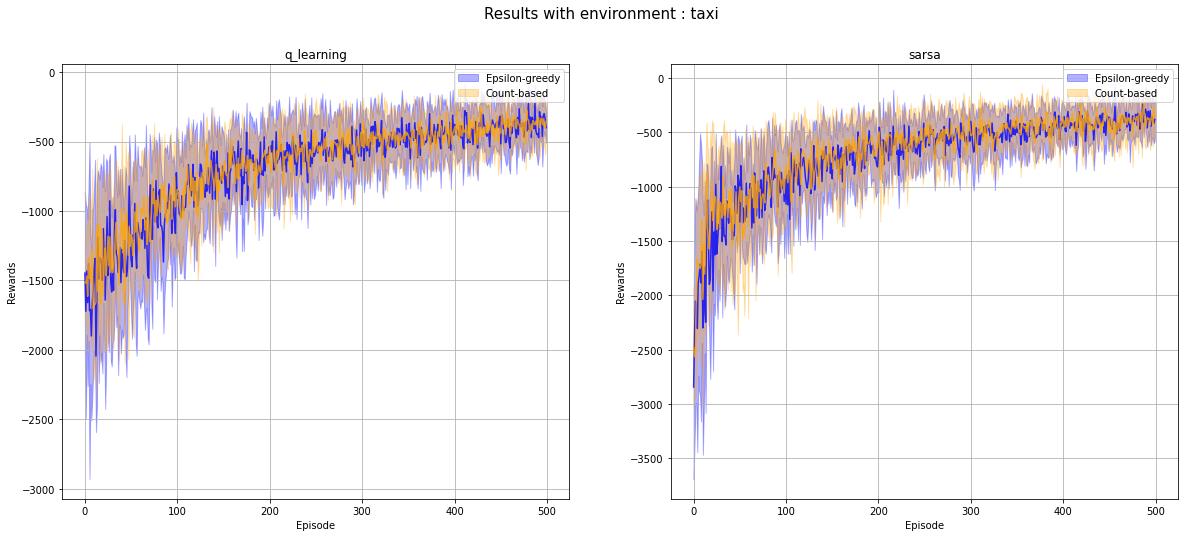

In [12]:
models_discrete[NAME_ENV].plot_results(figsize = (20,8),  nrows = 1, ncols = 2)

### Histograms of the states 

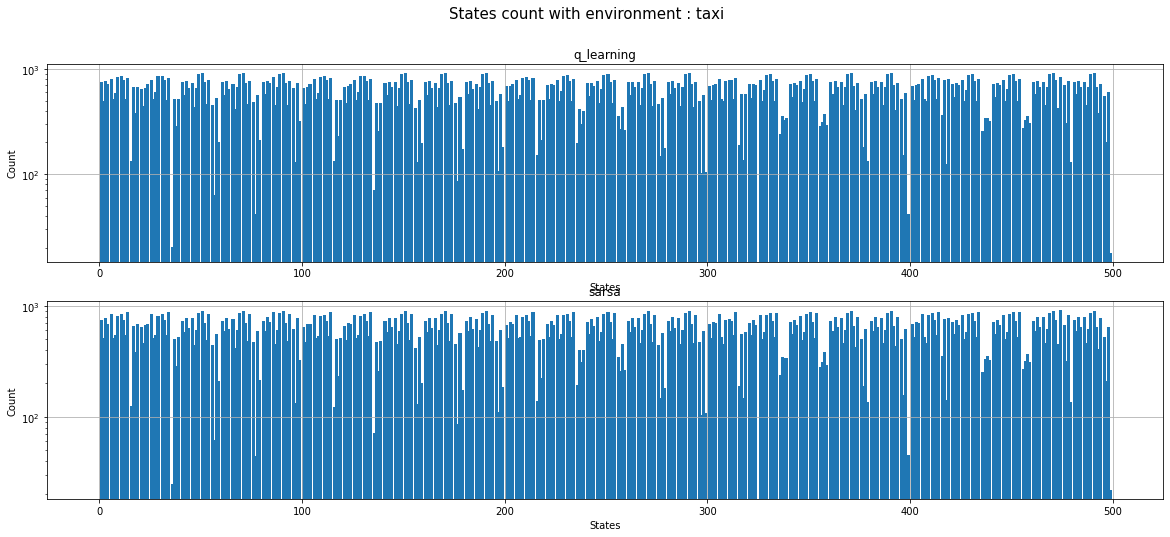

In [13]:
models_discrete[NAME_ENV].plot_histogram(figsize = (20,8), ncols = 1, nrows = 2)

## Acrobot 

### Hyperparameters

In [14]:
# Q-learning and Sarsa
all_params_discrete['acrobot']= {
      'q_learning' : 
            {
            'alpha' : 0.01,
            'gamma' : 0.99,
            'epsilon' : 0.1,
            'beta' : 0.1
            },
    'sarsa' : {
            'alpha' : 0.01,
            'gamma' : 0.99,
            'epsilon' : 0.1,
            'beta' : 0.1
              }
}

In [15]:
# Continuous deep RL 
all_params['acrobot'] = {
    'dqn' : 
            {
            'BUFFER_SIZE' : 500,
            'state_emb' : 64,
            'hidden_size' : 64,
            'batch_size' : 32,
            'gamma' : 0.99,
            'optimizer' : optim.Adam,
            'criterion' : nn.MSELoss(),
            'lr' : 1e-3 ,
            'device' : device,
            'k' : 16,
            'beta' : 0.1
            },
    'ddqn' : 
          {
          'BUFFER_SIZE' : 500,
          'state_emb' : 64,
          'hidden_size' : 64,
          'batch_size' : 32,
          'gamma' : 0.99,
          'optimizer' : optim.Adam,
          'criterion' : nn.MSELoss(),
          'lr' : 1e-3,
          'UPDATE_EVERY' : 10,
          'k' : 16,
          'beta' : 0.1,
          'device' : device
          },
    'dueling_dqn' : 
         {
           'BUFFER_SIZE' : 500,
            'state_emb' : 64,
            'hidden_size' : 64,
            'batch_size' : 64,
            'gamma' : 0.99,
            'optimizer' : optim.Adam,
            'criterion' : nn.MSELoss(),
            'lr' : 1e-3 ,
            'UPDATE_EVERY' : 10,
            'k' : 16,
            'beta' : 0.1,
            'device' : device
         }
}

In [16]:
CURRENT_ENV = ENVS['acrobot']
NAME_ENV = 'acrobot'

## Q-learning and Sarsa

In [17]:
models_discrete[NAME_ENV] = Models(name_env = NAME_ENV, hp_params = all_params_discrete[NAME_ENV])

In [18]:
models_discrete[NAME_ENV].initialise()

### Rewards 

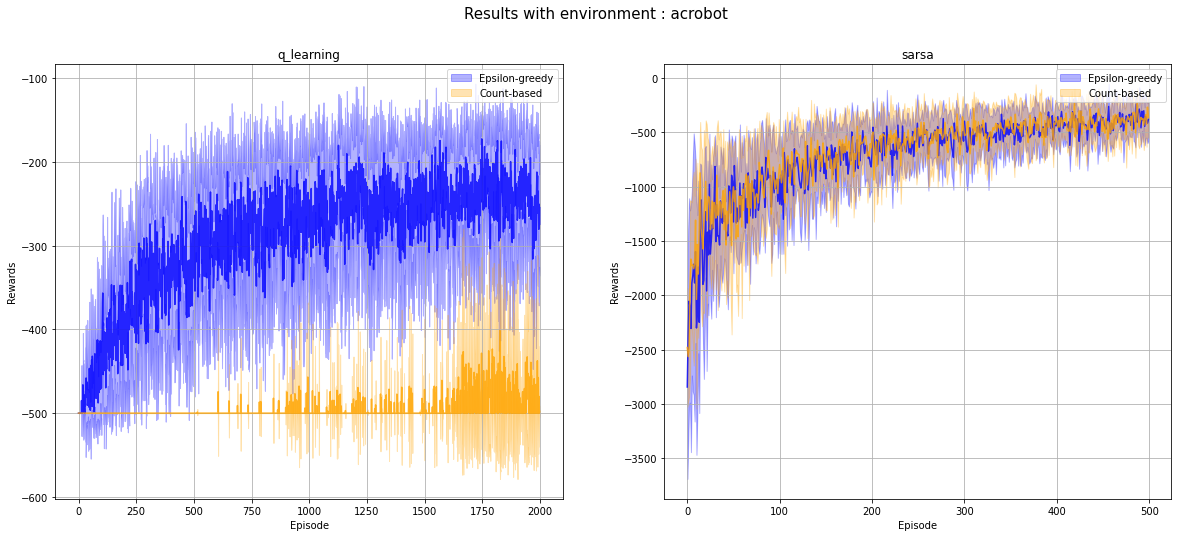

In [19]:
models_discrete[NAME_ENV].plot_results(figsize = (20,8),  nrows = 1, ncols = 2)

### Histograms of the states 

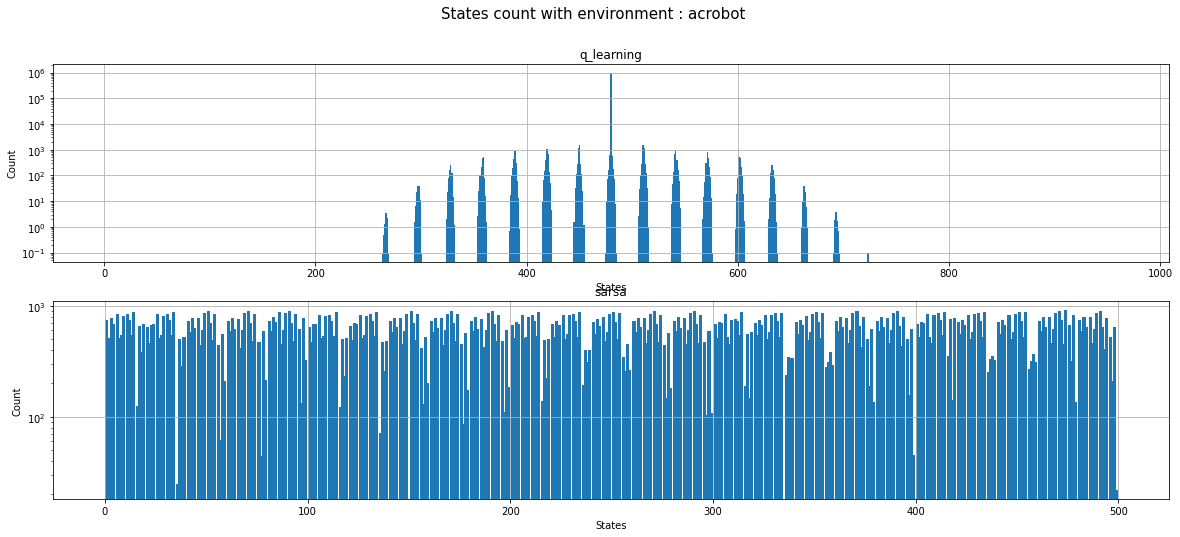

In [20]:
models_discrete[NAME_ENV].plot_histogram(figsize = (20,8), ncols = 1, nrows = 2)

## Deep RL 

In [21]:
models[NAME_ENV] = Models(name_env = NAME_ENV, hp_params = all_params[NAME_ENV])

In [22]:
models[NAME_ENV].initialise()

--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---


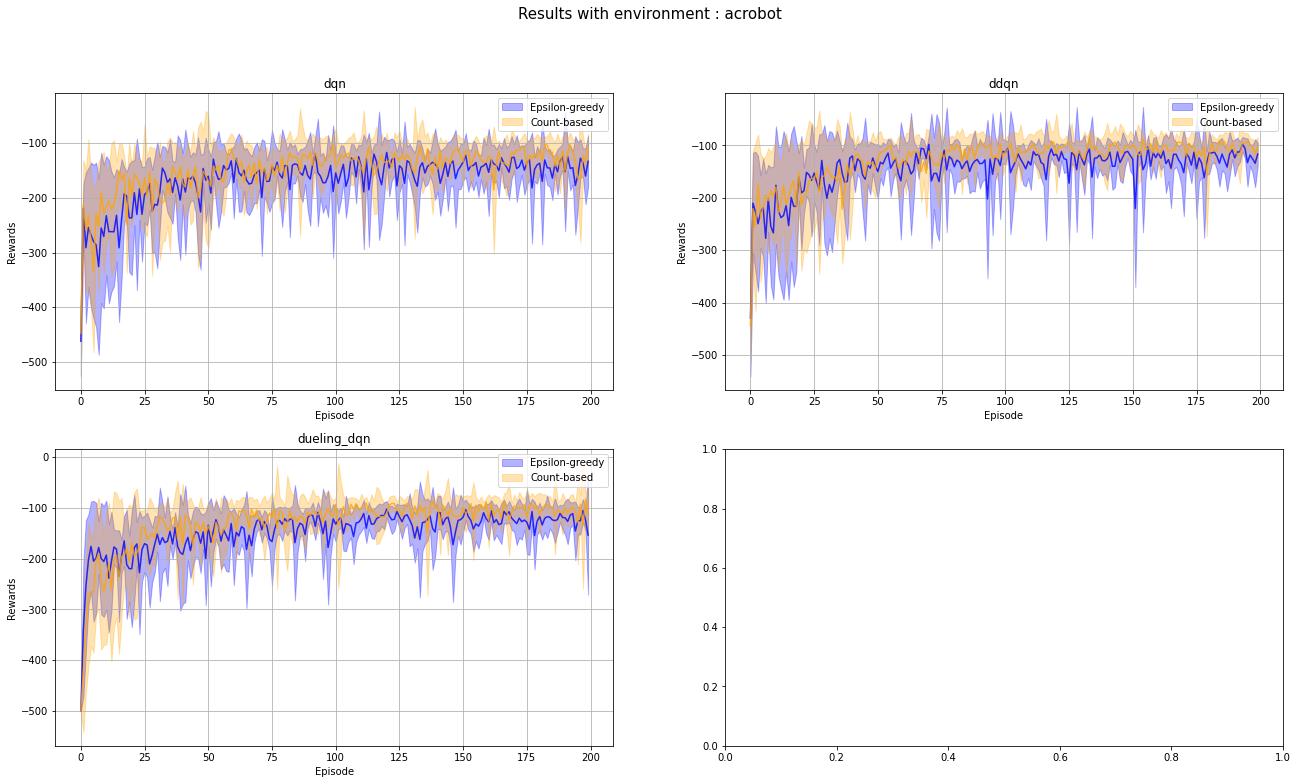

In [23]:
models[NAME_ENV].plot_results(figsize = (22,12),  nrows = 2, ncols = 2)

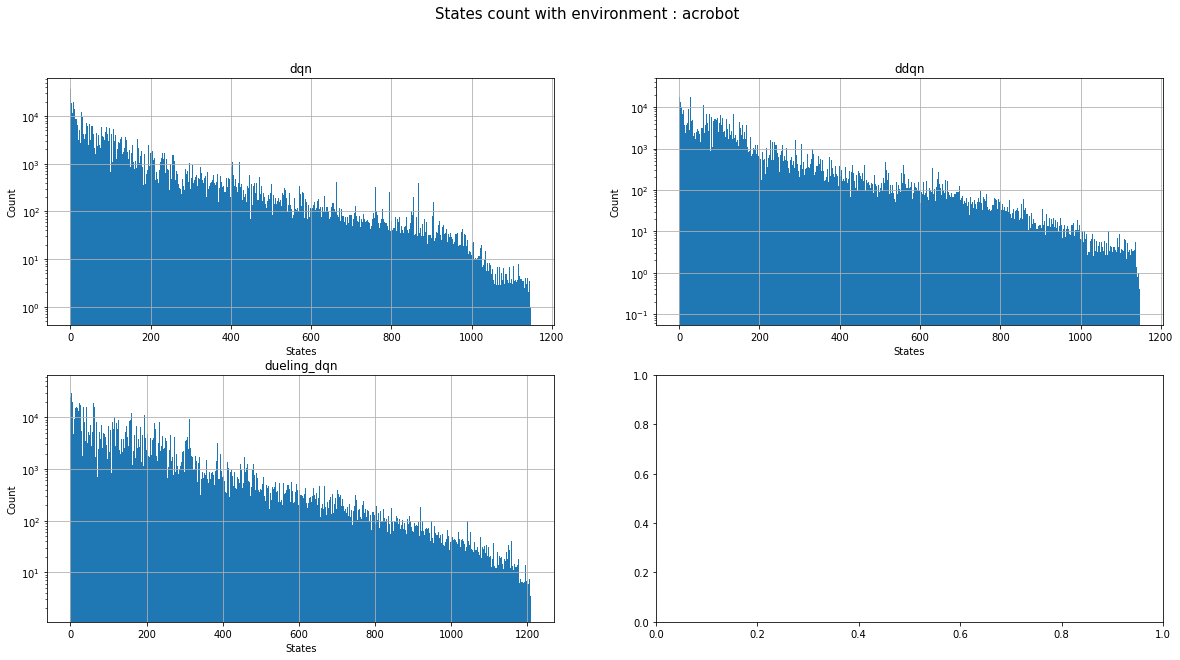

In [24]:
models[NAME_ENV].plot_histogram(figsize = (20,10), ncols = 2, nrows = 2)

## Cartpole

### Hyperparameters

In [25]:
# Continuous deep RL 
all_params['cartpole'] = {
    'dqn' : 
            {
            'BUFFER_SIZE' : 500,
            'state_emb' : 64,
            'hidden_size' : 128,
            'batch_size' : 64,
            'gamma' : 0.99,
            'optimizer' : optim.Adam,
            'criterion' : nn.MSELoss(),
            'lr' : 1e-3,
            'device' : device,
            'k' : 32,
            'beta' : 0.1
            },
    'ddqn' : 
          {
          'BUFFER_SIZE' : 1000,
          'state_emb' : 64,
          'hidden_size' : 64,
          'batch_size' : 32,
          'gamma' : 0.99,
          'optimizer' : optim.Adam,
          'criterion' : nn.MSELoss(),
          'lr' : 1e-3,
          'UPDATE_EVERY' : 50,
          'k' : 32,
          'beta' : 0.1,
          'device' : device
          },
    'dueling_dqn' : 
         {
           'BUFFER_SIZE' : 5000,
            'state_emb' : 128,
            'hidden_size' : 64,
            'batch_size' : 64,
            'gamma' : 0.99,
            'optimizer' : optim.Adam,
            'criterion' : nn.MSELoss(),
            'lr' : 1e-3 ,
            'UPDATE_EVERY' : 10,
            'k' : 32,
            'beta' : 0.9,
            'device' : device
         }
}

In [26]:
CURRENT_ENV = ENVS['cartpole']
NAME_ENV = 'cartpole'

In [27]:
models[NAME_ENV] = Models(name_env = NAME_ENV, hp_params = all_params[NAME_ENV])

In [28]:
models[NAME_ENV].initialise()

--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---


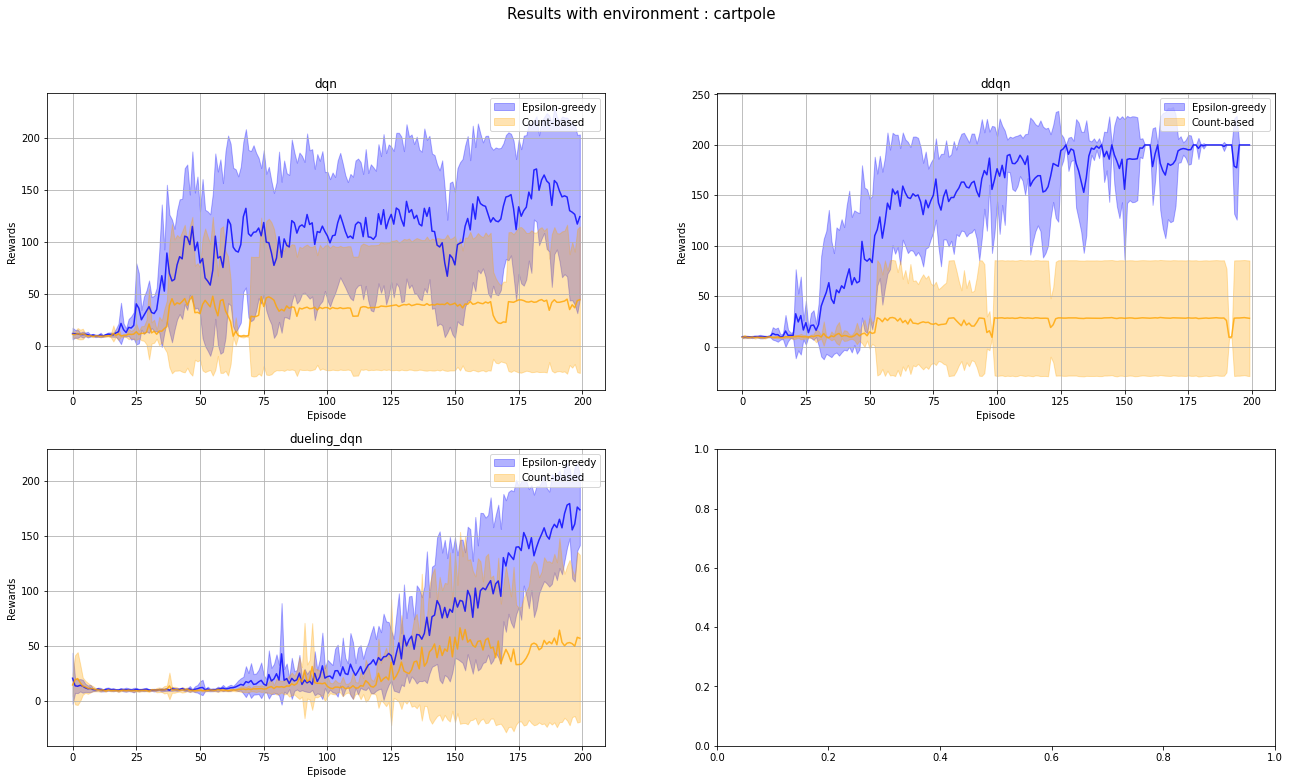

In [29]:
models[NAME_ENV].plot_results(figsize = (22,12),  nrows = 2, ncols = 2)

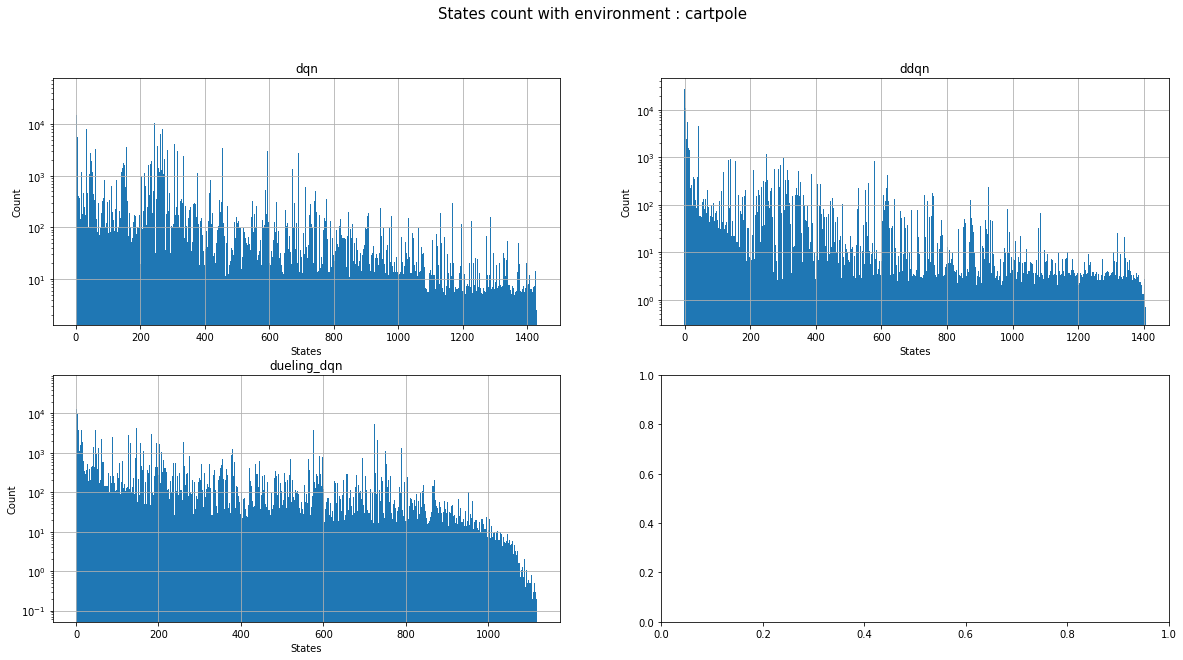

In [30]:
models[NAME_ENV].plot_histogram(figsize = (20,10), ncols = 2, nrows = 2)

## Mountain Car 

### Hyperparameters

In [31]:
# Continuous deep RL 
all_params['mountain'] = {
    'dqn' : 
            {
            'BUFFER_SIZE' : 1000,
            'state_emb' : 64,
            'hidden_size' : 64,
            'batch_size' : 64,
            'gamma' : 0.99,
            'optimizer' : optim.Adam,
            'criterion' : nn.MSELoss(),
            'lr' : 1e-3,
            'device' : device,
            'k' : 16   ,
            'beta' : 0.1
            },
    'ddqn' : 
          {
         'BUFFER_SIZE' : 5000,
          'state_emb' : 64,
          'hidden_size' : 64,
          'batch_size' : 32,
          'gamma' : 0.99,
          'optimizer' : optim.Adam,
          'criterion' : nn.MSELoss(),
          'lr' : 1e-3,
          'UPDATE_EVERY' : 50,
          'k' : 32,
          'beta' : 0.9,
          'device' : device
          },
    'dueling_dqn' : {
            'BUFFER_SIZE' : 10000,
            'state_emb' : 64,
            'hidden_size' : 128,
            'batch_size' : 64,
            'gamma' : 0.99,
            'optimizer' : optim.Adam,
            'criterion' : nn.MSELoss(),
            'lr' : 1e-3 ,
            'UPDATE_EVERY' : 10,
            'k' : 64,
            'beta' : 0.9,
            'device' : device
    }
}

In [32]:
CURRENT_ENV = ENVS['mountain']
NAME_ENV = 'mountain'

In [33]:
models[NAME_ENV] = Models(name_env = NAME_ENV, hp_params = all_params[NAME_ENV])

In [34]:
models[NAME_ENV].initialise()

--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---
--- Loading model checkpoint ---


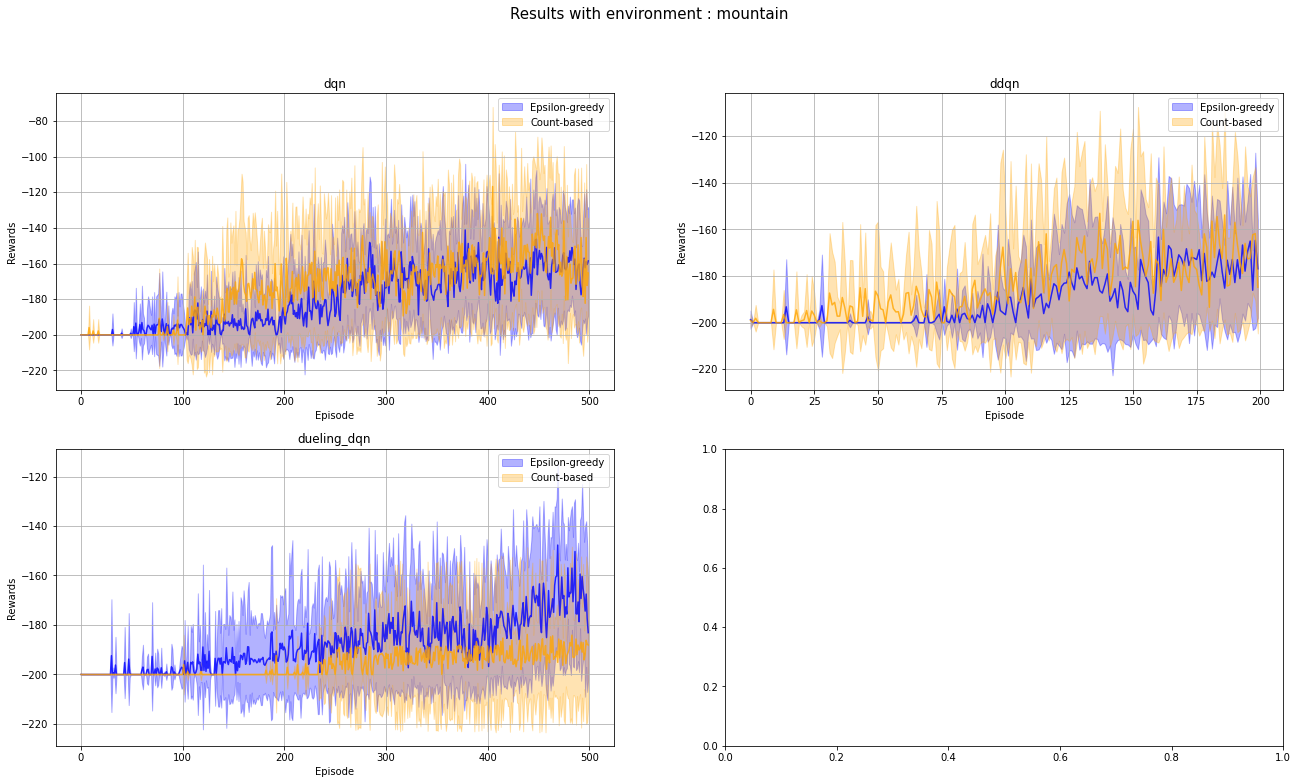

In [35]:
models[NAME_ENV].plot_results(figsize = (22,12),  nrows = 2, ncols = 2)

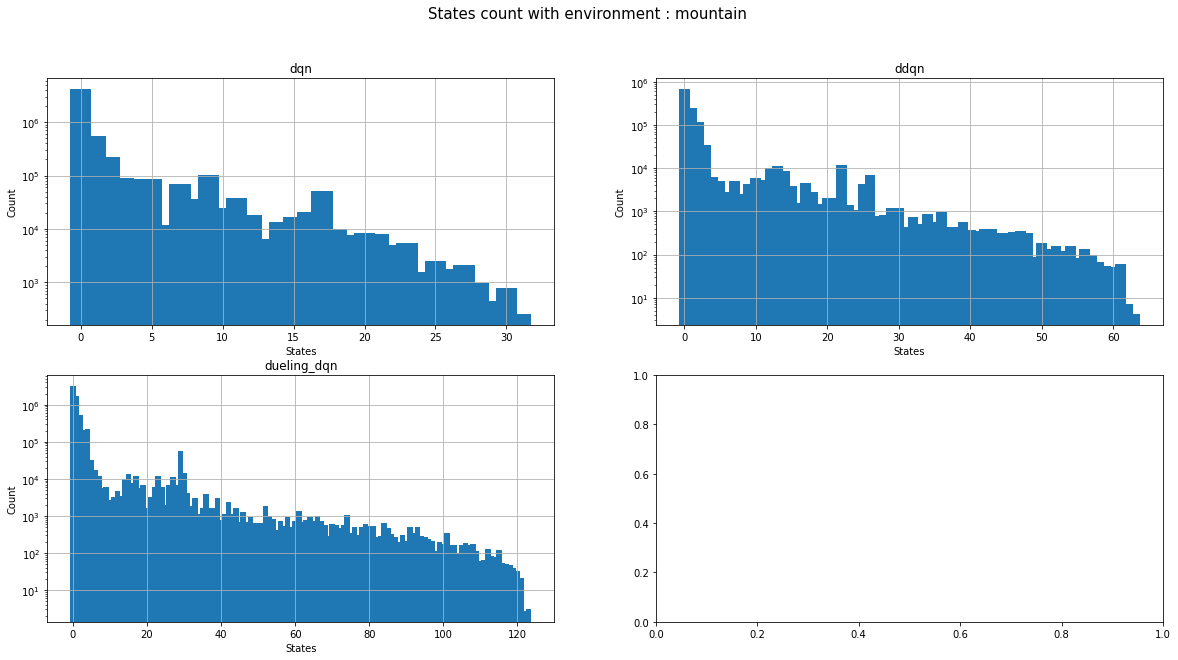

In [36]:
models[NAME_ENV].plot_histogram(figsize = (20,10), ncols = 2, nrows = 2)

# Predictions on environments

In [37]:
env = ENVS['acrobot']

In [38]:
model = models['acrobot'].models['ddqn'][0]

In [39]:
model.act(env.reset())

2

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [50]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [52]:
env.render()

ImportError: 
    Error occurred while running `from pyglet.gl import *`
    HINT: make sure you have OpenGL install. On Ubuntu, you can run 'apt-get install python-opengl'.
    If you're running on a server, you may need a virtual frame buffer; something like this should work:
    'xvfb-run -s "-screen 0 1400x900x24" python <your_script.py>'
    

In [60]:
def simulate(env, model, t_max = 500, save_every = 10) : 
  ''' Simulate the environment with the given model '''
  all_rewards = []
  frames = []
  render = lambda : (env.render(mode='rgb_array'))
  for i in range(10) : 
    current_rew = []
    state = env.reset()
    for ep in range(t_max) :
      action = model.act(state)
      state, reward, done, _ = env.step(action)
      current_rew.append(reward)  
      if done : 
        break
      if ep % save_every == 0 : 
        frames.append(render())

    all_rewards.append(current_rew) 
  return frames,all_rewards

In [61]:
frames,all_rewards = simulate(env, model)

ValueError: ignored

In [ ]:
# all_rew = []
# frames = []
# for i_episode in range(10):
#     state = env.reset()
#     for t in range(200):
#         # env.render()
#         action = dqagent.choose_action(state, 0)
#         state, reward, done, info = env.step(action)
#         if t%5 == 0 : 
            
#             frames.append(env.render(mode='rgb_array'))
#         if done:
#             print("Episode finished after {} timesteps".format(t+1))
#             all_rew.append(t)
#             break
        
# env.close()

In [47]:
import imageio

In [ ]:
imageio.mimsave('cartpole_dqn.gif', frames)

In [ ]:
im.save('out.gif', save_all=True, append_images=[im1, im2, ...])